In [101]:
import os
import glob
import copy
import time
import pickle
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import texttable as tt  
import latextable

#from data_loader import*
from data_preprocessing import*
from evaluation import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2,l1
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

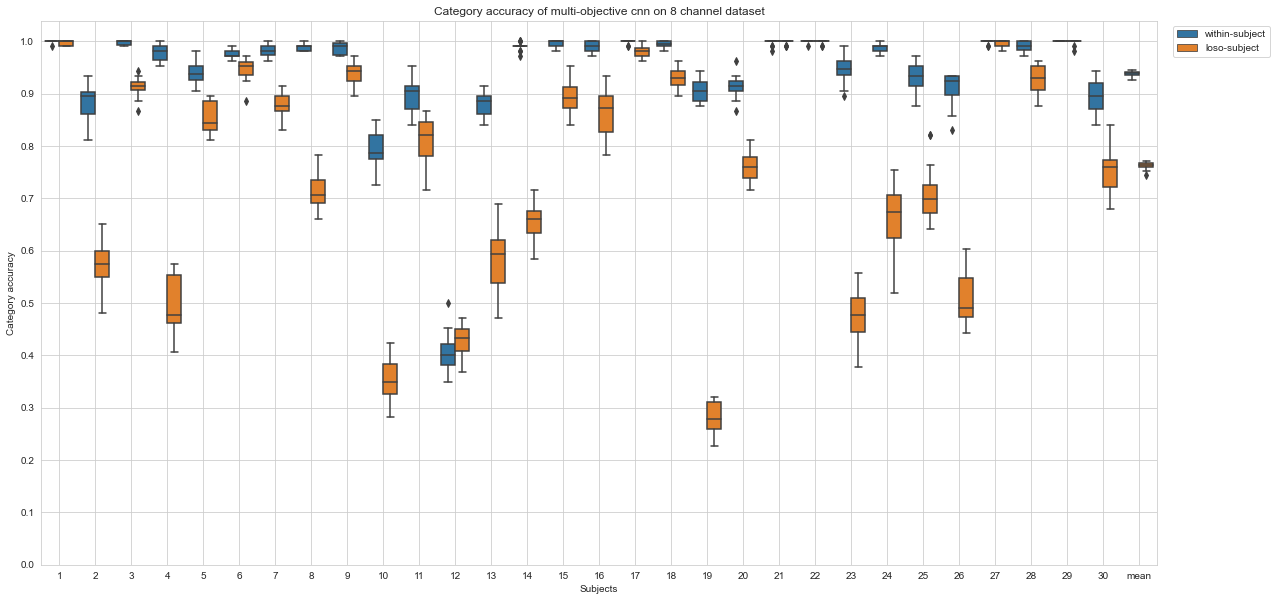

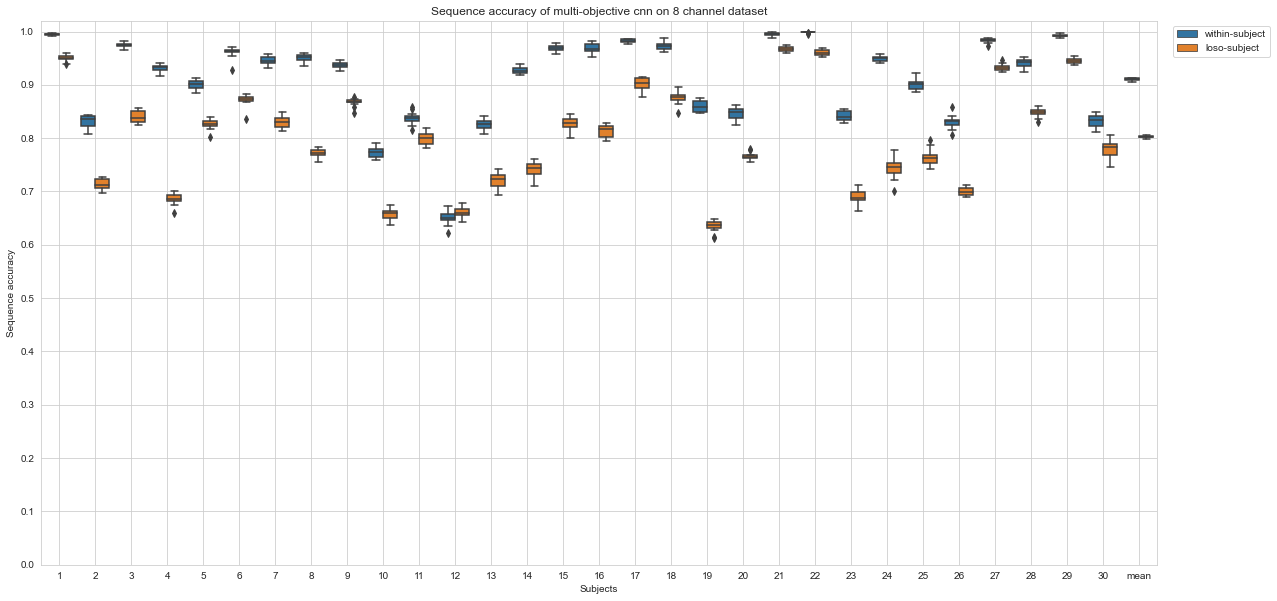

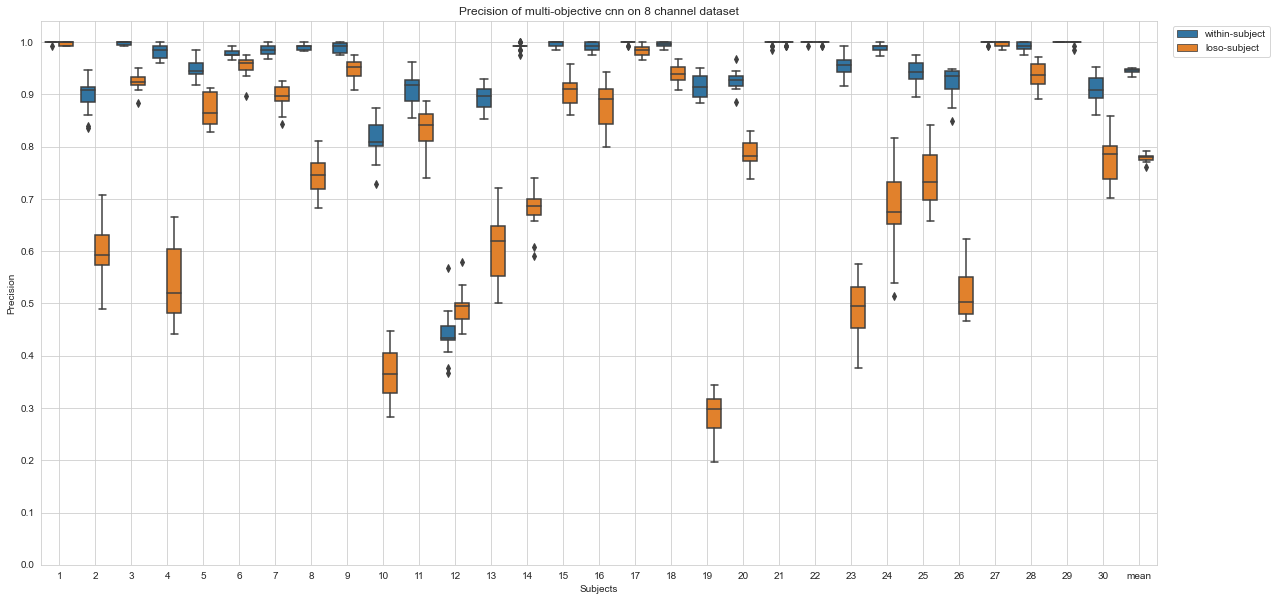

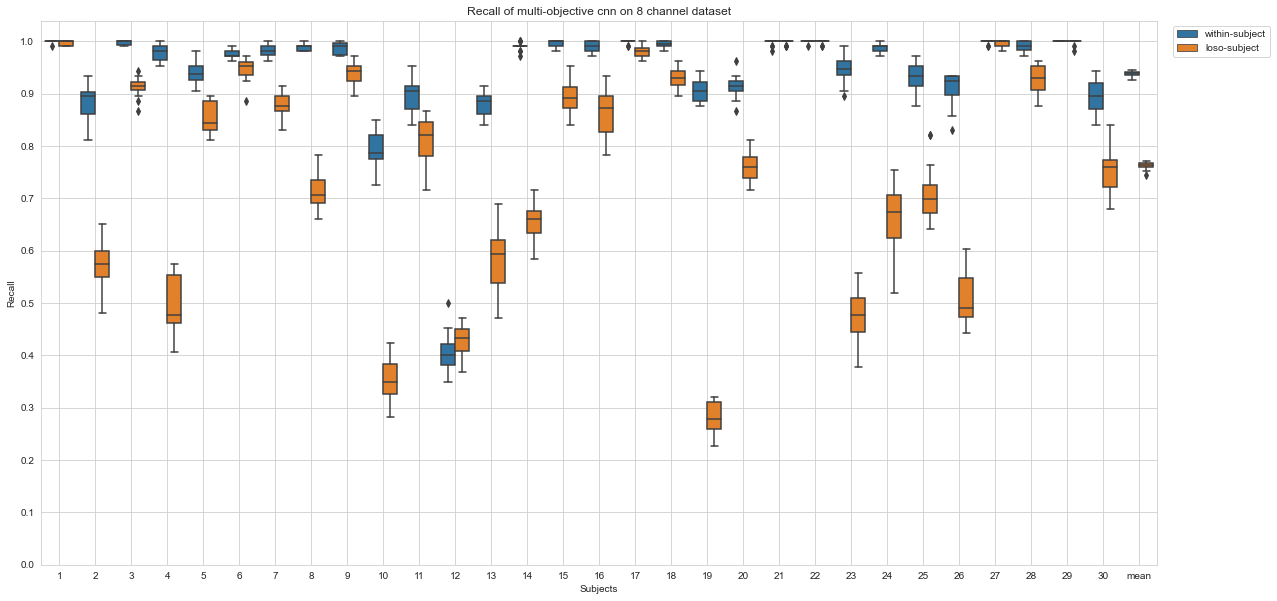

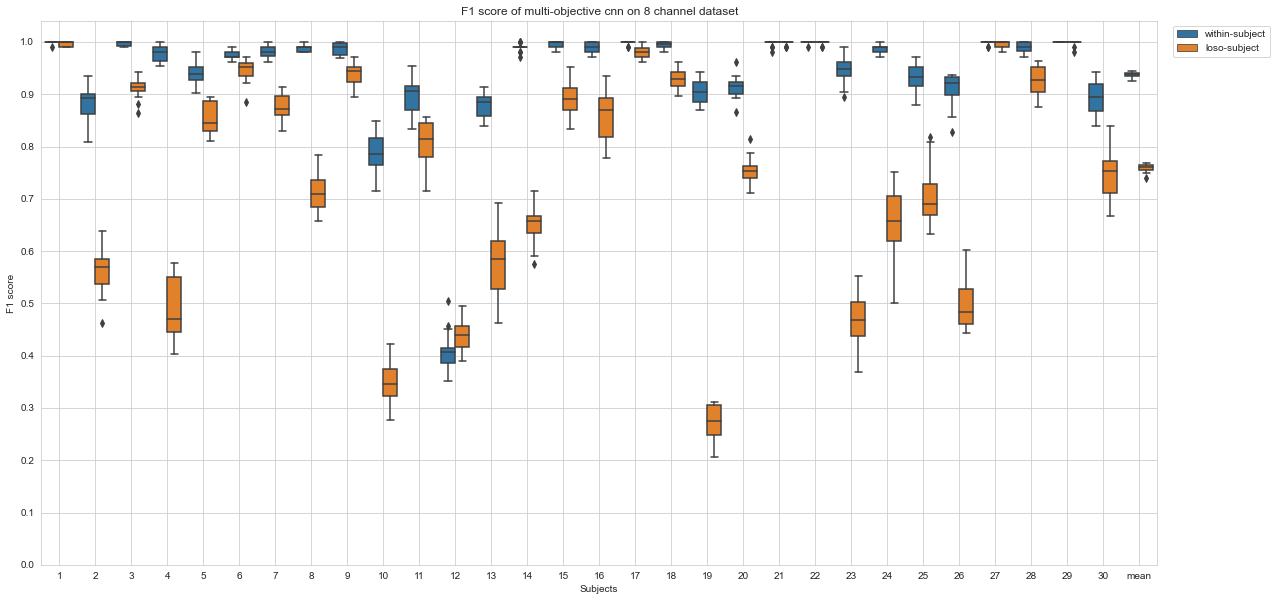

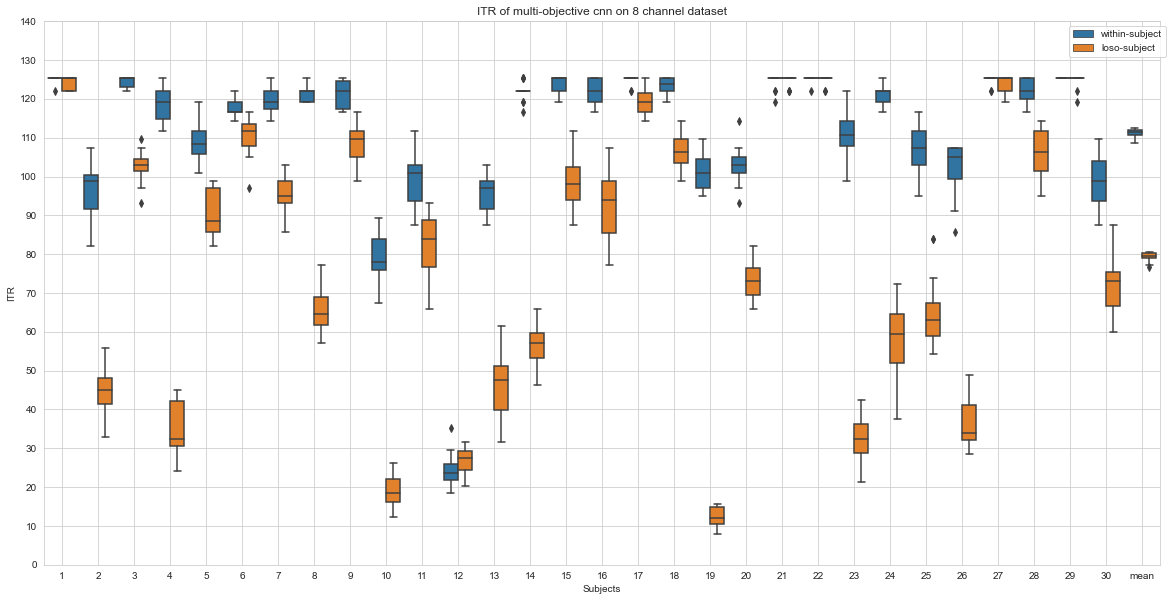

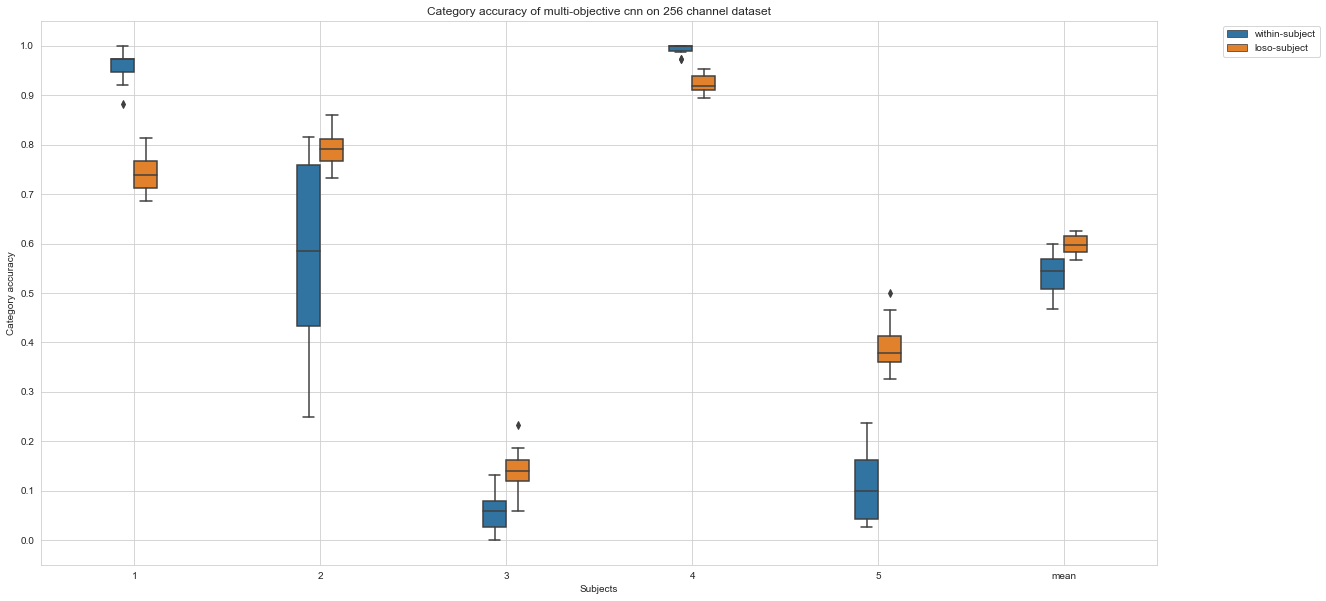

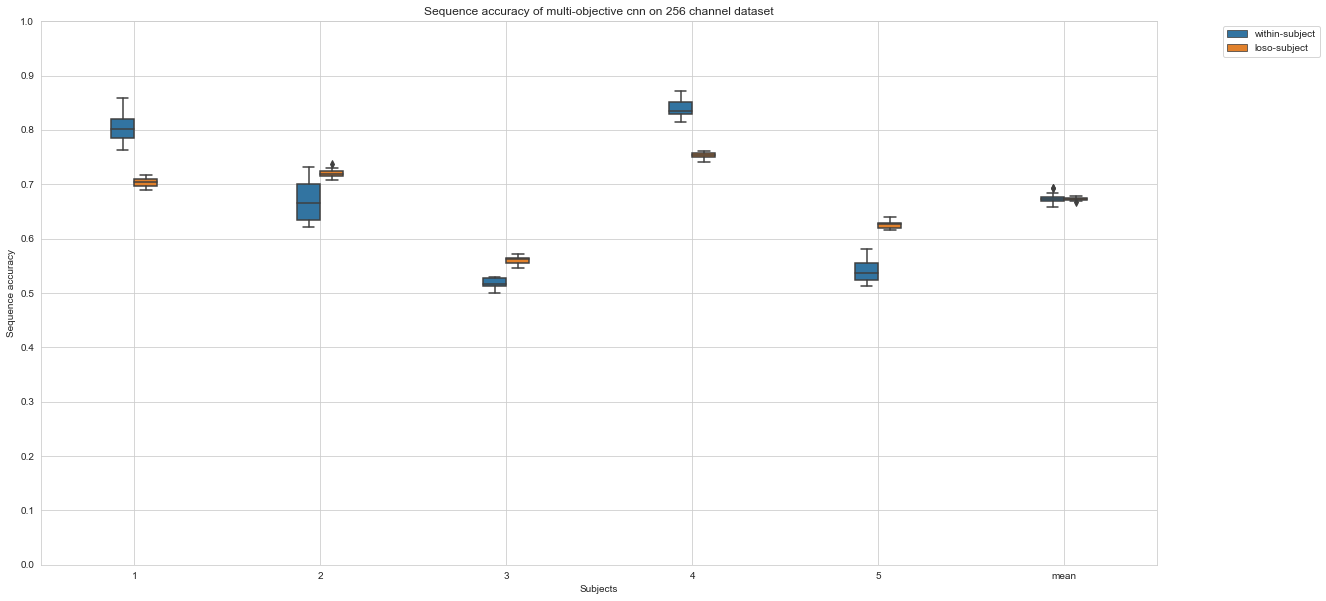

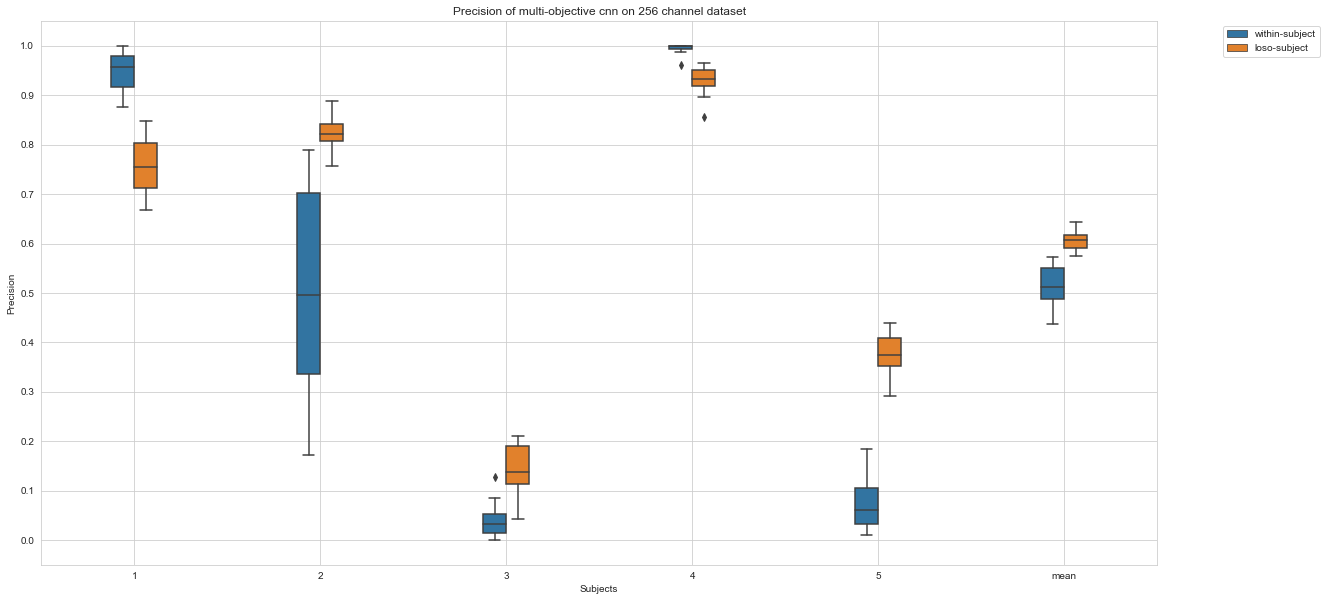

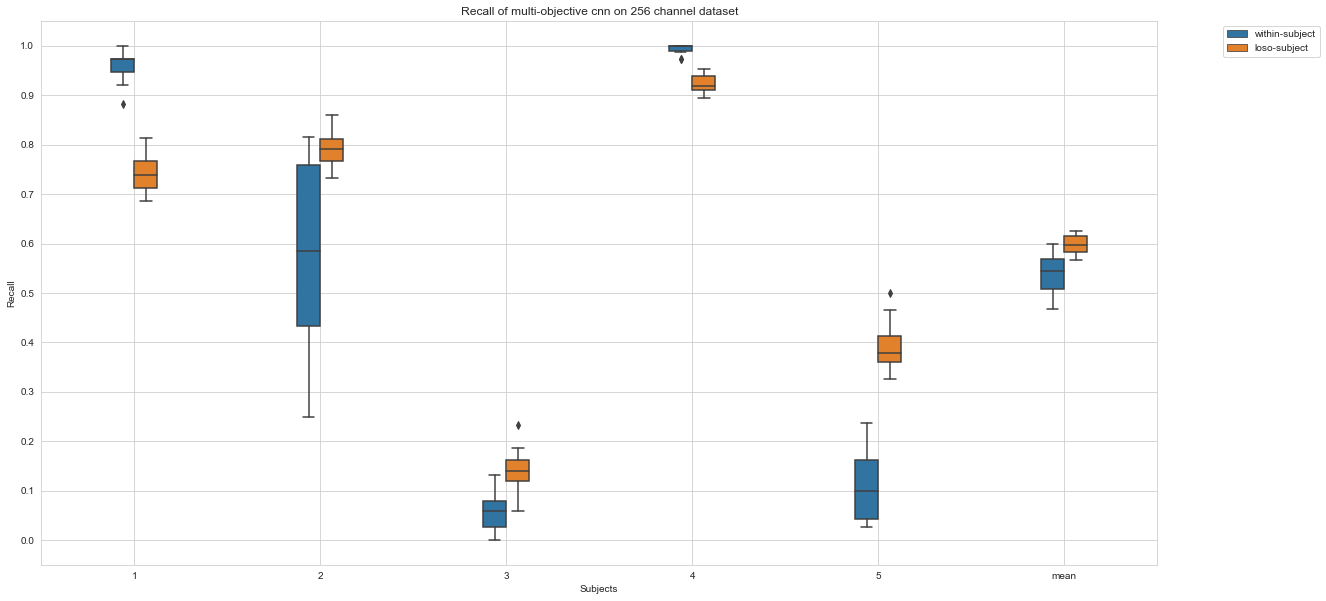

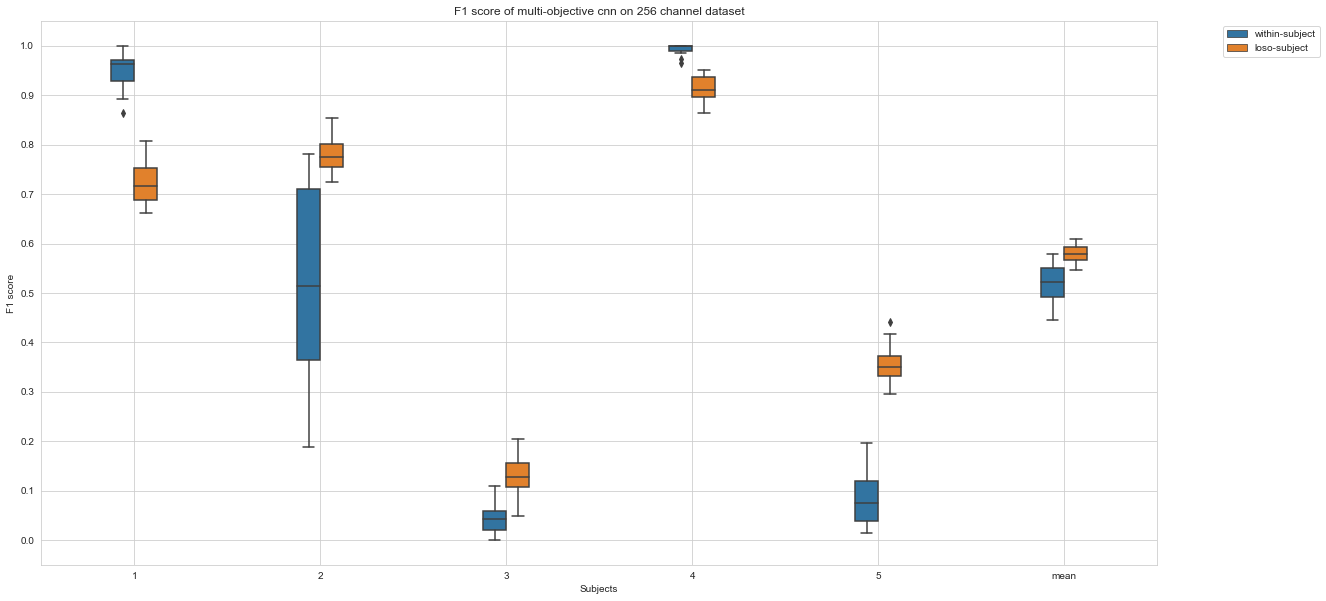

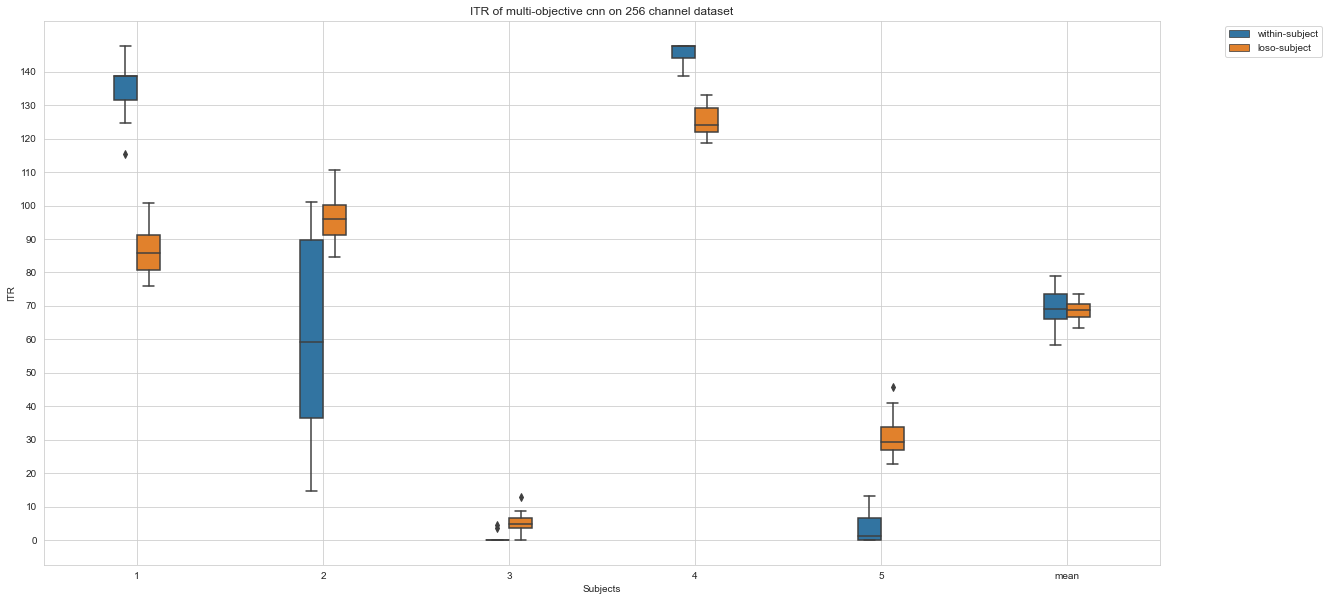

In [58]:
# Multi-objective cnn

model = 'multi_objective_cnn'
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject','loso_subject']
category_accuracy = {}
sequence_accuracy = {}
precision = {}
recall = {}
f1_score = {}
itr = {}
for dataset in datasets:
    category_accuracy[dataset] = {}
    sequence_accuracy[dataset] = {}
    precision[dataset] = {}
    recall[dataset] = {}
    f1_score[dataset] = {}
    itr[dataset] = {}
    for mode in modes:
        
        with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
            results = pickle.load(handle)
            #results = fix_roc(results,dataset)

        category_accuracy[dataset][mode] = get_results(results,dataset,'category_accuracy')
        sequence_accuracy[dataset][mode] = get_results(results,dataset,'sequence_accuracy')
        precision[dataset][mode] = get_results(results,dataset,'precision')
        recall[dataset][mode] = get_results(results,dataset,'recall')
        f1_score[dataset][mode] = get_results(results,dataset,'f1_score')
        itr[dataset][mode] = get_results(results,dataset,'ITR')
            
            
    boxplot_multi_objective_cnn(category_accuracy,dataset,'category_accuracy')
    boxplot_multi_objective_cnn(sequence_accuracy,dataset,'sequence_accuracy')
    boxplot_multi_objective_cnn(precision,dataset,'precision')
    boxplot_multi_objective_cnn(recall,dataset,'recall')
    boxplot_multi_objective_cnn(f1_score,dataset,'f1_score')
    boxplot_multi_objective_cnn(itr,dataset,'ITR')

In [119]:
category_accuracy[dataset][mode][2]

{1: 0.74883723, 2: 0.78759694, 3: 0.14186046, 4: 0.92093015, 5: 0.38372096}

In [120]:
modes = ['within_subject','loso_subject']
datasets = ['8_channel_cVEP','256_channel_cVEP']
for dataset in datasets:
    if(dataset=='8_channel_cVEP'):
        n_subjects = 30
        dataset_txt = '8-channel dataset'
    else:
        dataset_txt = '256-channel dataset'
        n_subjects = 5
        
    for mode in modes:
        results_table = np.zeros((n_subjects+1,7)).astype('object')
        columns = np.array(['Subject','category accuracy','sequence accuracy','precision','recall','f1 score','ITR'])
        num_decimals = 5
        results_table[0,:] = columns
        results_table[1:,0] = np.arange(1,n_subjects+1)
        results_table[1:,1] = np.around(np.array(list(category_accuracy[dataset][mode][2].values())),num_decimals)
        results_table[1:,2] = np.around(np.array(list(sequence_accuracy[dataset][mode][2].values())),num_decimals)
        results_table[1:,3] = np.around(np.array(list(precision[dataset][mode][2].values())),num_decimals)
        results_table[1:,4] = np.around(np.array(list(recall[dataset][mode][2].values())),num_decimals)
        results_table[1:,5] = np.around(np.array(list(f1_score[dataset][mode][2].values())),num_decimals)
        results_table[1:,6] = np.around(np.array(list(itr[dataset][mode][2].values())),num_decimals)

        if(mode=='within_subject'):
            mode_txt = 'Within-subject'
        else:
            mode_txt = 'LOSO-subject'
        
        table_1 = tt.Texttable()
        #table_1.set_cols_align(["l", "r", "c"])
        #table_1.set_cols_valign(["t", "m", "b"])
        table_1.add_rows(results_table)
        #print('-- Example 1: Basic --')
        #print('Texttable Output:')
        print("\n\n{} results for {}".format(mode_txt,dataset_txt))
        print(table_1.draw())
        print(latextable.draw_latex(table_1, caption="{} results of multi-objective cnn for {}".format(mode_txt,dataset_txt), 
                                    label="multi_objective_cnn_{}_{}".format(mode_txt,dataset_txt)))



Within-subject results for 8-channel dataset
+---------+-------------+------------+-----------+--------+----------+---------+
| Subject |  category   |  sequence  | precision | recall | f1 score |   ITR   |
|         |  accuracy   |  accuracy  |           |        |          |         |
+=========+=============+============+===========+========+==========+=========+
| 1       | 0.999       | 0.992      | 0.999     | 0.999  | 0.999    | 125.046 |
+---------+-------------+------------+-----------+--------+----------+---------+
| 2       | 0.884       | 0.830      | 0.900     | 0.884  | 0.882    | 96.564  |
+---------+-------------+------------+-----------+--------+----------+---------+
| 3       | 0.997       | 0.973      | 0.997     | 0.997  | 0.997    | 124.373 |
+---------+-------------+------------+-----------+--------+----------+---------+
| 4       | 0.977       | 0.928      | 0.981     | 0.977  | 0.977    | 118.536 |
+---------+-------------+------------+-----------+--------+---

In [12]:
subjects = ['Subjects']
#subjects.append(list(np.arange(1,3)))
subjects

['Subjects', [1, 2]]

In [31]:
subjects = np.array(['Subjects'])
a = list(np.arange(1,3).flatten())
subjects = np.append(subjects,a)
subjects

array(['Subjects', '1', '2'], dtype='<U11')

In [ ]:
# Comparison between classifiers

models = ['cca', 'multi_objective_cnn']
datasets = ['8_channel_cVEP','256_channel_cVEP']
modes = ['within_subject']

category_accuracy = {}
precision = {}
recall = {}
f1_score = {}
itr = {}
#sequence_accuracy = {}
for dataset in datasets:
    category_accuracy[dataset] = {}
    for mode in modes:
        category_accuracy[dataset][mode] = {}
        for model in models:
            with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
                results = pickle.load(handle)
                #results = fix_roc(results,dataset)
                
            category_accuracy[dataset][mode][model] = get_results(results,dataset,'category_acc')
            precision[dataset][mode][model] = get_results(results,dataset,'precision')
            recall[dataset][mode][model] = get_results(results,dataset,'recall')
            f1_score[dataset][mode][model] = get_results(results,dataset,'f1_score')
            itr[dataset][mode][model] = get_results(results,dataset,'ITR')
            
            
            #plot_roc_curve(results,model,dataset,mode)
            
        boxplot_results(category_accuracy,'category_accuracy')
        boxplot_results(precision,'precision')
        boxplot_results(recall,'recall')eval_txt
        boxplot_results(f1_score,'f1_score')
        boxplot_results(itr,'ITR')

In [7]:
results[1][1].keys()

dict_keys(['category_accuracy', 'ITR', 'category_cm', 'recall', 'precision', 'f1_score', 'fpr', 'tpr', 'auc', 'variable_time_steps', 'ITR_time_steps', 'pred_time_step'])

In [ ]:
#             if (model == 'multi_objective_cnn'):
#                 sequence_acc = get_sequence_acc(results,dataset)
#                 sequence_accuracy[dataset][mode][model] = sequence_acc

#             category_acc = get_category_acc(results,dataset)
#             if (model == 'multi_objective_cnn'):
#                 sequence_acc = get_sequence_acc(results,dataset)
#                 sequence_accuracy[dataset][mode][model] = sequence_acc

KeyError: '8_channel_cVEP'

In [ ]:
def plot_category_acc():



    df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
    df = df[['Subjects','CCA','Multi-objective CNN']]

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.set_style("whitegrid")
    dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
    sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
    ax.set_title('Within-subject accuracy (8_channel_cVEP)')
    ax.set(ylabel='Accuracy')
    ax.set(yticks=np.arange(0,1.001,0.1))
    ax.legend(bbox_to_anchor=(1.01, 1.0))
    plt.show()

In [24]:
model = 'cca'
dataset = '8_channel_cVEP'
n_subjects = 30
mode = 'within_subject'

with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results = pickle.load(handle)
    
category_acc = get_category_acc(results,30)

In [15]:
results.keys(),results[1].keys(),results[1][1].keys()

(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]),
 dict_keys(['category_accuracy', 'ITR', 'category_cm', 'recall', 'precision', 'f1_score', 'fpr', 'tpr', 'auc', 'variable_time_steps', 'ITR_time_steps', 'pred_time_step']))

In [11]:
model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'

with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results = pickle.load(handle)

In [12]:
results.keys(),results[1].keys(),results[1][1].keys()

(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]),
 dict_keys(['history', 'category_accuracy', 'sequence_accuracy', 'sequence_cm', 'category_cm', 'ITR', 'recall', 'precision', 'f1_score', 'fpr', 'tpr', 'auc', 'variable_time_steps', 'ITR_time_steps', 'pred_time_step']))

In [6]:
results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [ ]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)